In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [4]:

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define paths
base_dir = '../data/DAWN_processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Define classes (weather conditions)
classes = ['Fog', 'Rain', 'Snow', 'Sand']

# Define parameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 15
learning_rate = 0.001

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Using device: cuda


In [5]:

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Create data loaders

# Option 2 (preferred for most systems): Use multiple workers but disable pin_memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)
print(f"Classes: {train_dataset.classes}")
print(f"Class to idx mapping: {train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Classes: ['Fog', 'Rain', 'Sand', 'Snow']
Class to idx mapping: {'Fog': 0, 'Rain': 1, 'Sand': 2, 'Snow': 3}
Training samples: 718
Validation samples: 204
Test samples: 105


In [6]:

# Define CNN model
class WeatherCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(WeatherCNN, self).__init__()
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            # Fourth convolutional block
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
        )

        # Calculate final feature map dimensions
        # After 4 max-pooling layers with stride 2, dimensions are reduced by factor of 16
        final_h = img_height // 16
        final_w = img_width // 16

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * final_h * final_w, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Alternative: Use a pre-trained model
def create_pretrained_model(num_classes=4):
    model = models.resnet18(weights='IMAGENET1K_V1')
    # Freeze early layers
    for param in list(model.parameters())[:-4]:
        param.requires_grad = False
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Choose between custom CNN or pre-trained model
# model = WeatherCNN(num_classes=len(classes))
model = create_pretrained_model(num_classes=len(classes))
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

F:\DevCache\conda\envs\main\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    model.train()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total

        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        # Update learning rate
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

    return model, history

# Evaluation function
def evaluate_model(model, data_loader, criterion=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader.dataset) if criterion else 0
    acc = 100 * correct / total

    return avg_loss, acc

# Plot function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history['train_acc'])
    ax1.plot(history['val_acc'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    ax2.plot(history['train_loss'])
    ax2.plot(history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Confusion matrix function
def plot_confusion_matrix(model, data_loader, classes):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    return y_true, y_pred

# Visualize predictions function
def visualize_predictions(model, data_loader, classes, num_images=12):
    model.eval()

    # Get a batch of images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_images], labels[:num_images]

    # Make predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()

    # Plot images with predictions
    fig = plt.figure(figsize=(15, 10))

    for i in range(num_images):
        # Add subplot
        ax = fig.add_subplot(3, 4, i + 1)

        # Un-normalize the image for display
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Display the image
        ax.imshow(img)

        # Add titles
        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        title_color = 'green' if labels[i] == predicted[i] else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

# Function to predict a single image
def predict_image(model, image_path, classes, transform=None):
    if transform is None:
        transform = val_test_transforms

    # Load and preprocess the image
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]
        _, predicted_idx = torch.max(probabilities, 0)

    # Get the predicted class and confidence
    predicted_class = classes[predicted_idx.item()]
    confidence = probabilities[predicted_idx].item()

    # Get all class probabilities
    all_probs = {classes[i]: prob.item() for i, prob in enumerate(probabilities)}

    return {
        'class': predicted_class,
        'confidence': confidence,
        'all_probabilities': all_probs
    }

Starting training...


Epoch 1/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.82it/s, loss=0.893, acc=38.9]


Epoch 1/15: Train Loss: 1.2969, Train Acc: 38.86%, Val Loss: 1.1720, Val Acc: 50.00%


Epoch 2/15 [Train]: 100%|██████████| 23/23 [00:05<00:00,  3.89it/s, loss=0.956, acc=61.8]


Epoch 2/15: Train Loss: 0.9934, Train Acc: 61.84%, Val Loss: 0.9041, Val Acc: 68.14%


Epoch 3/15 [Train]: 100%|██████████| 23/23 [00:05<00:00,  4.08it/s, loss=0.917, acc=69.8]


Epoch 3/15: Train Loss: 0.8334, Train Acc: 69.78%, Val Loss: 0.8854, Val Acc: 66.67%


Epoch 4/15 [Train]: 100%|██████████| 23/23 [00:05<00:00,  3.93it/s, loss=0.571, acc=70.8]


Epoch 4/15: Train Loss: 0.7774, Train Acc: 70.75%, Val Loss: 0.7230, Val Acc: 77.45%


Epoch 5/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.79it/s, loss=0.572, acc=72.6]


Epoch 5/15: Train Loss: 0.7319, Train Acc: 72.56%, Val Loss: 0.6857, Val Acc: 76.47%


Epoch 6/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.81it/s, loss=0.914, acc=74]  


Epoch 6/15: Train Loss: 0.6768, Train Acc: 73.96%, Val Loss: 0.6517, Val Acc: 79.41%


Epoch 7/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.82it/s, loss=0.921, acc=78.4]


Epoch 7/15: Train Loss: 0.6144, Train Acc: 78.41%, Val Loss: 0.6735, Val Acc: 74.51%


Epoch 8/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.72it/s, loss=0.785, acc=75.2]


Epoch 8/15: Train Loss: 0.6269, Train Acc: 75.21%, Val Loss: 0.6479, Val Acc: 73.53%


Epoch 9/15 [Train]: 100%|██████████| 23/23 [00:05<00:00,  3.85it/s, loss=0.588, acc=79.5]


Epoch 9/15: Train Loss: 0.5852, Train Acc: 79.53%, Val Loss: 0.6297, Val Acc: 75.00%


Epoch 10/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.67it/s, loss=0.695, acc=79.7]


Epoch 10/15: Train Loss: 0.5575, Train Acc: 79.67%, Val Loss: 0.5802, Val Acc: 78.92%


Epoch 11/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.72it/s, loss=0.602, acc=79.9]


Epoch 11/15: Train Loss: 0.5653, Train Acc: 79.94%, Val Loss: 0.5645, Val Acc: 79.41%


Epoch 12/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.68it/s, loss=0.415, acc=76.3]


Epoch 12/15: Train Loss: 0.5767, Train Acc: 76.32%, Val Loss: 0.5462, Val Acc: 79.41%


Epoch 13/15 [Train]: 100%|██████████| 23/23 [00:06<00:00,  3.74it/s, loss=0.78, acc=79.7] 


Epoch 13/15: Train Loss: 0.5315, Train Acc: 79.67%, Val Loss: 0.5451, Val Acc: 79.41%


Epoch 14/15 [Train]: 100%|██████████| 23/23 [00:05<00:00,  3.85it/s, loss=0.641, acc=81.9]


Epoch 14/15: Train Loss: 0.5163, Train Acc: 81.89%, Val Loss: 0.5345, Val Acc: 78.92%


Epoch 15/15 [Train]: 100%|██████████| 23/23 [00:05<00:00,  3.88it/s, loss=0.502, acc=79.7]


Epoch 15/15: Train Loss: 0.5486, Train Acc: 79.67%, Val Loss: 0.5364, Val Acc: 80.39%
Loaded best model with validation loss: 0.5345
Model saved as 'weather_classification_model.pth'


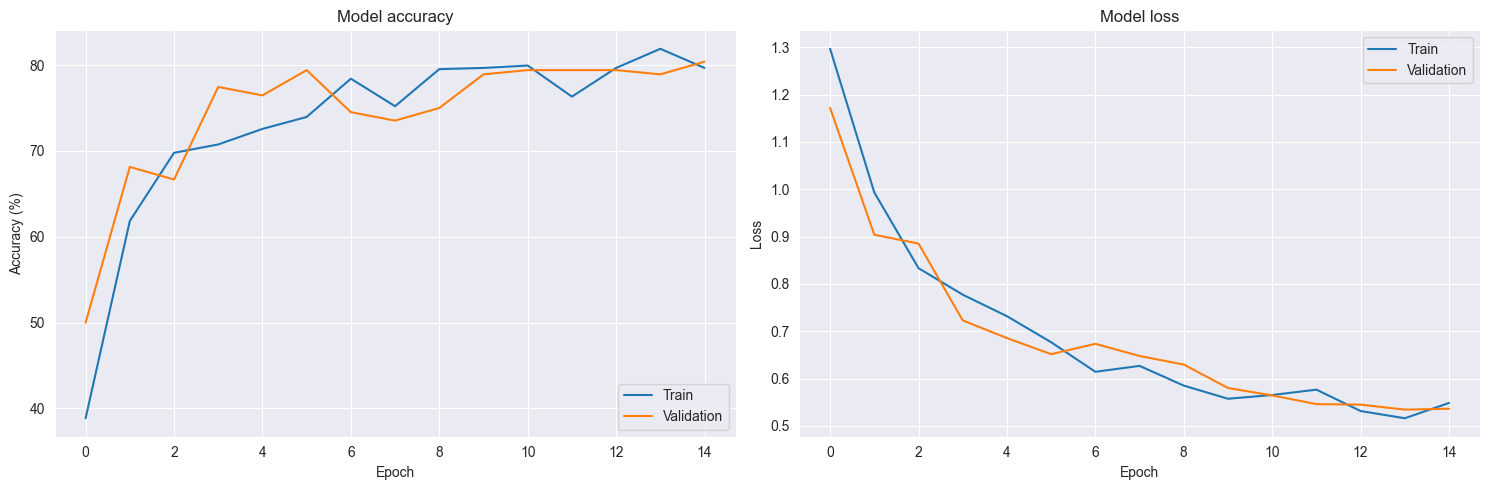

Test Loss: 0.7031, Test Accuracy: 73.33%


Generating predictions: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


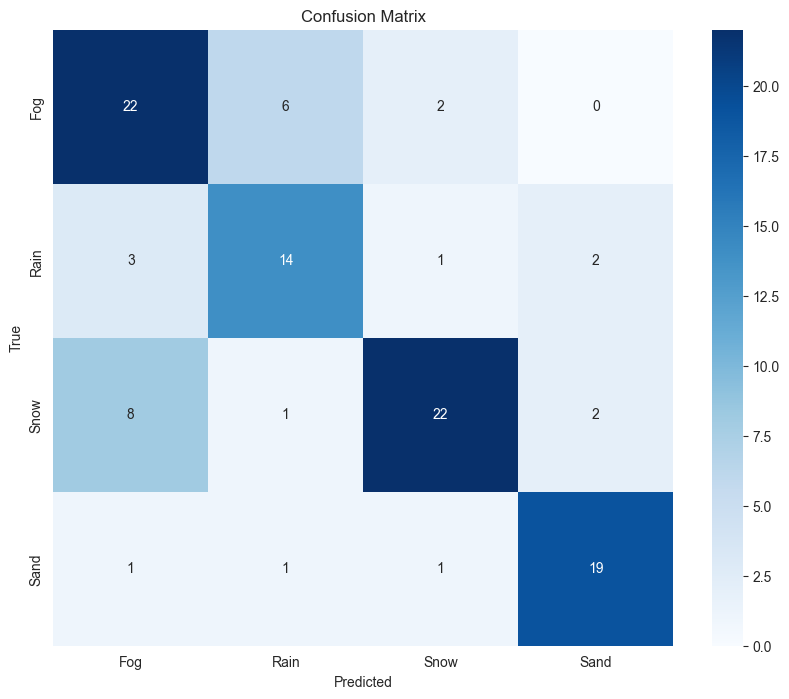


Classification Report:
              precision    recall  f1-score   support

         Fog       0.65      0.73      0.69        30
        Rain       0.64      0.70      0.67        20
        Snow       0.85      0.67      0.75        33
        Sand       0.83      0.86      0.84        22

    accuracy                           0.73       105
   macro avg       0.74      0.74      0.74       105
weighted avg       0.75      0.73      0.73       105



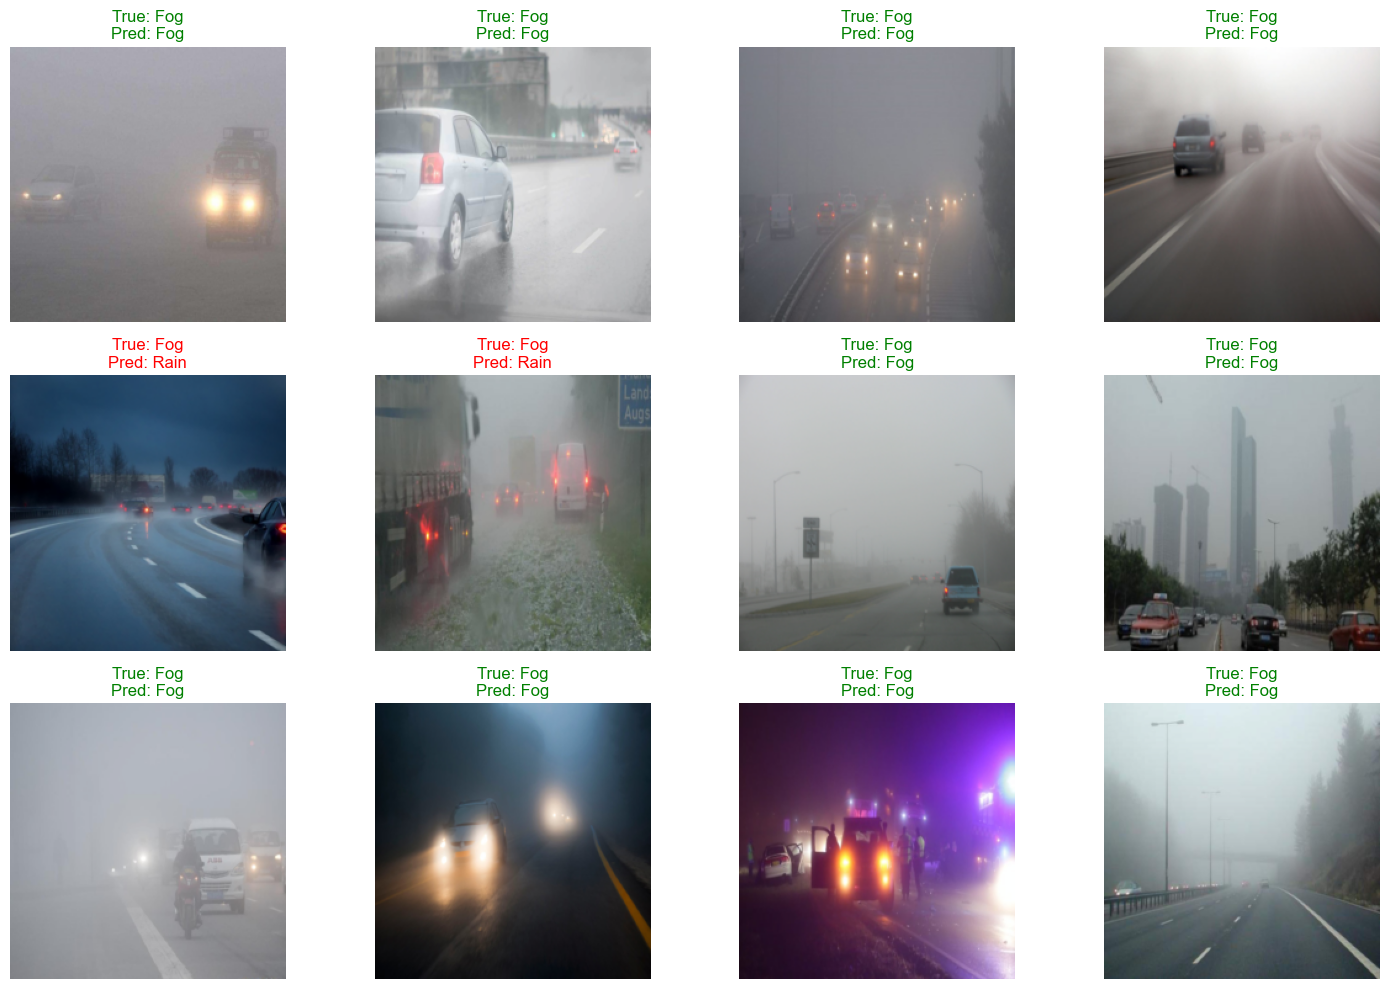

In [8]:

# Main execution
if __name__ == "__main__":
    # Train model
    print("Starting training...")
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

    # Save the model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'classes': classes,
    }, 'weather_classification_model.pth')
    print("Model saved as 'weather_classification_model.pth'")

    # Plot training history
    plot_training_history(history)

    # Evaluate on test data
    test_loss, test_acc = evaluate_model(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # Plot confusion matrix
    y_true, y_pred = plot_confusion_matrix(model, test_loader, classes)

    # Visualize some test predictions
    visualize_predictions(model, test_loader, classes)

    # Example usage of the prediction function:
    # result = predict_image(model, 'path/to/your/image.jpg', classes)
    # print(f"Predicted class: {result['class']} with {result['confidence']:.2f} confidence")

# Function to load the saved model for later use
def load_model(model_path, num_classes=4):
    checkpoint = torch.load(model_path)

    # Create a new model instance
    model = create_pretrained_model(num_classes=num_classes)

    # Load the saved state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    return model, checkpoint['classes']

# Example of loading and using the model:
# model, classes = load_model('weather_classification_model.pth')
# result = predict_image(model, 'path/to/your/image.jpg', classes)